# Figure 4 : Surface energy balance trends
Use the phd_v3 environment (can be replicated from the .yml file in envs/)

In [1]:
import xarray as xr
#import rioxarray as rxr
import xesmf as xe
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter

from pyproj import CRS,Transformer,Proj

import sys
sys.path.insert(1, '/home/castelli/Notebooks/PhD/utils') # to include my util file in previous directory
import utils as u
u.check_python_version()

3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]


In [2]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/MARgrid_EUe.nc')

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
lon = np.array(ds.LON[jmin:jmax,imin:imax])
lat = np.array(ds.LAT[jmin:jmax,imin:imax])
H = np.array(ds.SH[jmin:jmax,imin:imax])
nlat,nlon = 91, 139

normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True,
                 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
big_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True,
              'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[41.,50],'lonlim':[0.,20.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2,
                    'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}


In [3]:
ds_big = xr.open_dataset('/bettik/castelli/data/MAR-MPI-ESM/v3.14/bigdomain/MARgrid_EUn.nc')[["LON","LAT","SH","FRV","VEG"]]

In [4]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool_(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False


In [5]:
# function for seasonal mean (from Ian)
def season_mean(ds, calendar="standard"):
    #make a DataArray with the season of each day
    seas_array = ds.time.dt.season
    
    # count days in winter season (varies with leap years)
    nb_DJF = seas_array.str.count('DJF').sum()
    
    wgt_DJF = 1/nb_DJF.values.item()
    wgt_MAM = 1/(31+30+31)
    wgt_JJA = 1/(30+31+31)
    wgt_SON = 1/(30+31+30)

    weight = seas_array.str.replace('DJF',str(wgt_DJF)).str.replace('MAM',str(wgt_MAM)).str.replace('JJA',str(wgt_JJA)).str.replace('SON',str(wgt_SON))
    weight = weight.astype('float')
    
    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weight.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weight).groupby("time.season").sum(dim="time")

In [6]:
def make_ds_seas(path,simcode,vars,first_year,last_year):

    # creating seasonal dataarray with all vars

    ds_yrs = xr.open_dataset(path+'.EU'+simcode+'.'+vars[0]+'.'+str(first_year)+'.nc')#.resample(time='D').mean()

    for var in vars[1:]:
        ds_var = xr.open_dataset(path+'.EU'+simcode+'.'+var+'.'+str(first_year)+'.nc')#.resample(time='D').mean()
        ds_yrs[var] = ds_var[var]


    ds_yrs = season_mean(ds_yrs).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))

    for year in range(first_year+1,last_year+1):
        print(year,end=' ')
        ds_singleyr = xr.open_dataset(path+'.EU'+simcode+'.'+vars[0]+'.'+str(year)+'.nc')#.resample(time='D').mean()

        for var in vars[1:]:
            ds_var = xr.open_dataset(path+'.EU'+simcode+'.'+var+'.'+str(year)+'.nc')#.resample(time='D').mean()
            ds_singleyr[var] = ds_var[var]
    
        print('Computing season mean',end=' ')
        ds_singleyr = season_mean(ds_singleyr).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
        ds_yrs = xr.concat([ds_yrs,ds_singleyr], dim='Year')

    yrs = np.arange(first_year,last_year+1)
    ds_yrs = ds_yrs.assign_coords(Year=("Year", yrs))

    return ds_yrs
    

In [7]:
def altitude_lev_slopes(dataset_slopes,levels):
    ds_slopes_Hlev = dataset_slopes.where(levels[0]).mean(dim=('x','y'))
    ds_slopes_Hlev_std = dataset_slopes.where(levels[0]).std(dim=('x','y'))

    for lev in range(1,len(levels)):
        ds_slopes_Hlev = xr.concat([ds_slopes_Hlev,dataset_slopes.where(levels[lev]).mean(dim=('x','y'))], dim='Hlev')
        ds_slopes_Hlev_std = xr.concat([ds_slopes_Hlev_std,dataset_slopes.where(levels[lev]).std(dim=('x','y'))], dim='Hlev')

    ds_slopes_Hlev = ds_slopes_Hlev.assign_coords(Hlev=("Hlev", H_levels))
    ds_slopes_Hlev_std = ds_slopes_Hlev_std.assign_coords(Hlev=("Hlev", H_levels))

    return ds_slopes_Hlev, ds_slopes_Hlev_std

In [8]:
def find_snowline(path,first_year,last_year,mm_snow_thresh,N):
    
    minH_snow = np.zeros(((last_year-first_year+1),365))
    maxH_nosnow = np.zeros(((last_year-first_year+1),365))

    for year in list(range(first_year,last_year+1)):
        print(year,end=' ')

        hist_path = path+'/HIST/ICE.MPI-ESM_HIST.EUn.MB.'+str(year)+'.nc'
        scenario_path = path+'/SSP585/ICE.MPI-ESM_SSP585.EUn.MB.'+str(year)+'.nc'
        if year <2015:
            ds_snow = xr.open_dataset(hist_path)
        else:
            ds_snow = xr.open_dataset(scenario_path)
        
        array_snow = ds_snow.MB.max(axis=1)[:,jmin:jmax,imin:imax]
        nb_days = array_snow.shape[0]
        where_snow = (array_snow >= mm_snow_thresh)
        
        where_snowalps = np.logical_and(where_snow, np.repeat(alps[np.newaxis,:,:],nb_days,axis=0))
        
        where_no_snow = (array_snow < mm_snow_thresh)
        
        where_no_snowalps = np.logical_and(where_no_snow, np.repeat(alps[np.newaxis,:,:],nb_days,axis=0))
        
        for i in range(365):
            snowalps_msk_H = np.ma.masked_array(H,mask=np.invert(where_snowalps[i]))
            no_snowalps_msk_H = np.ma.masked_array(H,mask=np.invert(where_no_snowalps[i]))
                
            if (where_snowalps[i].sum() == 0): # if there is no snow, take the highest altitude where there is no snow to avoid mask
                minH_snow[year-first_year,i] = np.sort(no_snowalps_msk_H[no_snowalps_msk_H.mask==False],axis=None)[-1:]
            else:
                minH_snow[year-first_year,i] = np.sort(snowalps_msk_H,axis=None)[:N].mean()
                
            if (where_no_snowalps[i].sum() == 0): # if there is snow everywhere, take the lowest altitude where there is
                                                       # snow to avoid mask
                maxH_nosnow[year-first_year,i] = np.sort(snowalps_msk_H,axis=None)[:1]
            else:
                maxH_nosnow[year-first_year,i] = np.sort(no_snowalps_msk_H[no_snowalps_msk_H.mask==False],axis=None)[-N:].mean()
    
    return minH_snow, maxH_nosnow, (maxH_nosnow+minH_snow)/2

In [9]:
# Levels (altitude bands)

levels = [np.logical_and(alps,H<400), np.logical_and(alps,np.logical_and(H>=400,H<600)), np.logical_and(alps,np.logical_and(H>=600,H<800)),
          np.logical_and(alps,np.logical_and(H>=800,H<1000)), np.logical_and(alps,np.logical_and(H>=1000,H<1200)), np.logical_and(alps,np.logical_and(H>=1200,H<1400)),
          np.logical_and(alps,np.logical_and(H>=1400,H<1600)), np.logical_and(alps,np.logical_and(H>=1600,H<1800)), np.logical_and(alps,np.logical_and(H>=1800,H<2000)),
          np.logical_and(alps,np.logical_and(H>=2000,H<2200)), np.logical_and(alps,np.logical_and(H>=2200,H<2400)), np.logical_and(alps,np.logical_and(H>=2400,H<2600)),
          np.logical_and(alps,np.logical_and(H>=2600,H<2800)), np.logical_and(alps,np.logical_and(H>=2800,H<3000)),
          np.logical_and(alps,H>=3000)]#,
          #alps]

H_levels = [300,500,700,900,1100,1300,1500,1700,1900,2100,2300,2500,2700,2900,3100]

#### Snowline calculation

In [17]:
mean10_minH_snow, mean10_maxH_nosnow, mean10_ave_snow = find_snowline('/bettik/castelli/data/MAR-MPI-ESM/v3.14/bigdomain',1961,2100,1,10)

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [18]:
mean10_snowline = [mean10_minH_snow,mean10_maxH_nosnow,mean10_ave_snow]

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/daily_snowline_minmaxaverage_mean10pix_v314.npy', mean10_snowline)

#### Variable preparation

In [ ]:
# Might have to split the making of the dataset in two, as with all the variables at once the kernel can die
ds314_MPI_SSP585 = make_ds_seas(path='/bettik/castelli/data/MAR-MPI-ESM/v3.14/bigdomain/SSP585/ICE.MPI-ESM_SSP585',simcode='n',
                                vars=['TTz','TTmin','TTmax','ST','LWD','LWU','SWD','SWU','SHF','LHF','GF','HAcc','SWt','MB','MBmTop','MBrTop'],
                                first_year=2015,last_year=2100)

2016 Computing season mean 2017 Computing season mean 2018 Computing season mean 2019 Computing season mean 2020 Computing season mean 2021 Computing season mean 2022 Computing season mean 2023 Computing season mean 2024 Computing season mean 2025 Computing season mean 2026 Computing season mean 2027 Computing season mean 2028 Computing season mean 2029 Computing season mean 2030 Computing season mean 2031 Computing season mean 2032 Computing season mean 2033 Computing season mean 2034 Computing season mean 2035 Computing season mean 2036 Computing season mean 2037 Computing season mean 2038 Computing season mean 2039 Computing season mean 2040 Computing season mean 2041 Computing season mean 2042 Computing season mean 2043 Computing season mean 2044 Computing season mean 2045 Computing season mean 2046 Computing season mean 2047 Computing season mean 2048 Computing season mean 2049 Computing season mean 2050 Computing season mean 2051 Computing season mean 2052 Computing season mean 2

In [ ]:
# Computing net shortwave and net longwave and saving it
yrs = np.arange(2015,2101)

ds314_MPI_SSP585 = ds314_MPI_SSP585.assign_coords(Year=("Year", yrs))

ds314_MPI_SSP585['NSW'] = ds314_MPI_SSP585['SWD'] - ds314_MPI_SSP585['SWU']
ds314_MPI_SSP585['NLW'] = ds314_MPI_SSP585['LWD'] - ds314_MPI_SSP585['LWU']

ds314_MPI_SSP585['SWt'] = - ds314_MPI_SSP585['SWt'] # - sign for SWt because the energy transmitted to lower layers is LOST by the surface

# Computing energy flux related to melt and refreeze
ds_sect = ds_big
Lf = 3.34*10**5 # J.kg**(-1) the latent heat of fusion of water
t_timestep = 60*60*24 # 60*60*24 seconds in a day

melt_MBm_top = ds314_MPI_SSP585.MBmTop.sel(sector=1.0)*np.array(ds_sect.FRV.sel(sector=1.0))/100 + \
                ds314_MPI_SSP585.MBmTop.sel(sector=2.0)*np.array(ds_sect.FRV.sel(sector=2.0))/100 + \
                ds314_MPI_SSP585.MBmTop.sel(sector=3.0)*np.array(ds_sect.FRV.sel(sector=3.0))/100
ds_day_melt_top = melt_MBm_top * Lf / t_timestep
ds314_MPI_SSP585 = ds314_MPI_SSP585.assign(melt = -ds_day_melt_top) # minus sign becausemelt energy is lost from surface

freez_MBm_top = ds314_MPI_SSP585.MBrTop.sel(sector=1.0)*np.array(ds_sect.FRV.sel(sector=1.0))/100 + \
                ds314_MPI_SSP585.MBrTop.sel(sector=2.0)*np.array(ds_sect.FRV.sel(sector=2.0))/100 + \
                ds314_MPI_SSP585.MBrTop.sel(sector=3.0)*np.array(ds_sect.FRV.sel(sector=3.0))/100
ds_day_freez_top = freez_MBm_top * Lf / t_timestep
ds314_MPI_SSP585 = ds314_MPI_SSP585.assign(freeze = ds_day_freez_top) 

In [ ]:
ds314_MPI_SSP585.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/ds314_Surfbal_vars_2015_2100_seas.npy')

## Loading variables

In [10]:
path = '/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/'
ds314_MPI_SSP585 = xr.open_dataset(path + 'ds314_Surfbal_vars_2015_2100_seas.npy').isel(atmlay=0).sel(ztqlev=2.0)

ds314_MPI_SSP585

<xarray.Dataset>
Dimensions:     (x: 139, y: 91, sector: 3, season: 4, Year: 86)
Coordinates:
  * x           (x) float32 -259.0 -252.0 -245.0 -238.0 ... 693.0 700.0 707.0
  * y           (y) float32 -168.0 -161.0 -154.0 -147.0 ... 448.0 455.0 462.0
  * sector      (sector) float32 1.0 2.0 3.0
  * season      (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * Year        (Year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
    ztqlev      float32 2.0
    atmlay      float32 0.9997
Data variables: (12/25)
    LWD         (Year, season, y, x) float64 ...
    LWU         (Year, season, y, x) float64 ...
    SWD         (Year, season, y, x) float64 ...
    SWU         (Year, season, y, x) float64 ...
    SHF         (Year, season, y, x) float64 ...
    LHF         (Year, season, y, x) float64 ...
    ...          ...
    TTmax       (Year, season, y, x) float64 ...
    MBmTop      (Year, season, sector, y, x) float64 ...
    MBrTop      (Year, season, sector, y, x) float64 ...
    melt_top    (Year, season, y, x) float64 ...
    freeze_top  (Year, season, y, x) float64 ...
    ST          (Year, season, y, x) float64 ...

In [11]:
mean10_snowline = np.load('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/daily_snowline_minmaxaverage_mean10pix_v314.npy')

In [12]:
# Computing the surface balance from the other variables in case we want to check it

ds314_MPI_SSP585['Surfbal'] = ds314_MPI_SSP585['NSW'] + ds314_MPI_SSP585['NLW'] + ds314_MPI_SSP585['SHF'] + ds314_MPI_SSP585['LHF'] + ds314_MPI_SSP585['GF'] + \
                                ds314_MPI_SSP585['melt_top'] + ds314_MPI_SSP585['freeze_top'] + ds314_MPI_SSP585['HAcc'] + ds314_MPI_SSP585['SWt']


In [13]:
# Seasonal snowline

mean10_minH_snow_seas = np.full((140,4),np.nan)
mean10_maxH_nosnow_seas = np.full((140,4),np.nan)
mean10_average_minmax_snow_seas = np.full((140,4),np.nan)

mean10_snowline_seas = [mean10_minH_snow_seas,mean10_maxH_nosnow_seas,mean10_average_minmax_snow_seas]

for j in range(3):
    mean10_snowline_seas[j][:,0] = np.median(np.concatenate((mean10_snowline[j][:,:59],mean10_snowline[j][:,334:365]),axis=1),axis=1)
    mean10_snowline_seas[j][:,1] = np.median(mean10_snowline[j][:,59:151],axis=1)
    mean10_snowline_seas[j][:,2] = np.median(mean10_snowline[j][:,151:243],axis=1)
    mean10_snowline_seas[j][:,3] = np.median(mean10_snowline[j][:,243:334],axis=1)

In [14]:
# Excluding non physical values

ds314_MPI_SSP585 = ds314_MPI_SSP585.where(ds314_MPI_SSP585 != -np.inf)


In [15]:
# Renaming the variables
ds314_MPI_SSP585 = ds314_MPI_SSP585.rename_vars({"TTz": "T2m", "TTmax": "Tmax", "TTmin": "Tmin", "melt_top": "Melt top", "freeze_top": "Freeze top"})

### Making the plot

/tmp/ipykernel_1508098/3311289336.py:21: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=14, large=12)
/tmp/ipykernel_1508098/3311289336.py:21: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=14, large=12)
/tmp/ipykernel_1508098/3311289336.py:98: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=14, large=12)
/tmp/ipykernel_1508098/3311289336.py:98: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=14, large=12)
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/proplot/axes/base.py:2634: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1466657bd750> has a label of '_no_label' which cannot be automatically added to the legend.
  return mlegend.Legend(self, *args, ncol=ncol, **kwargs)
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-p

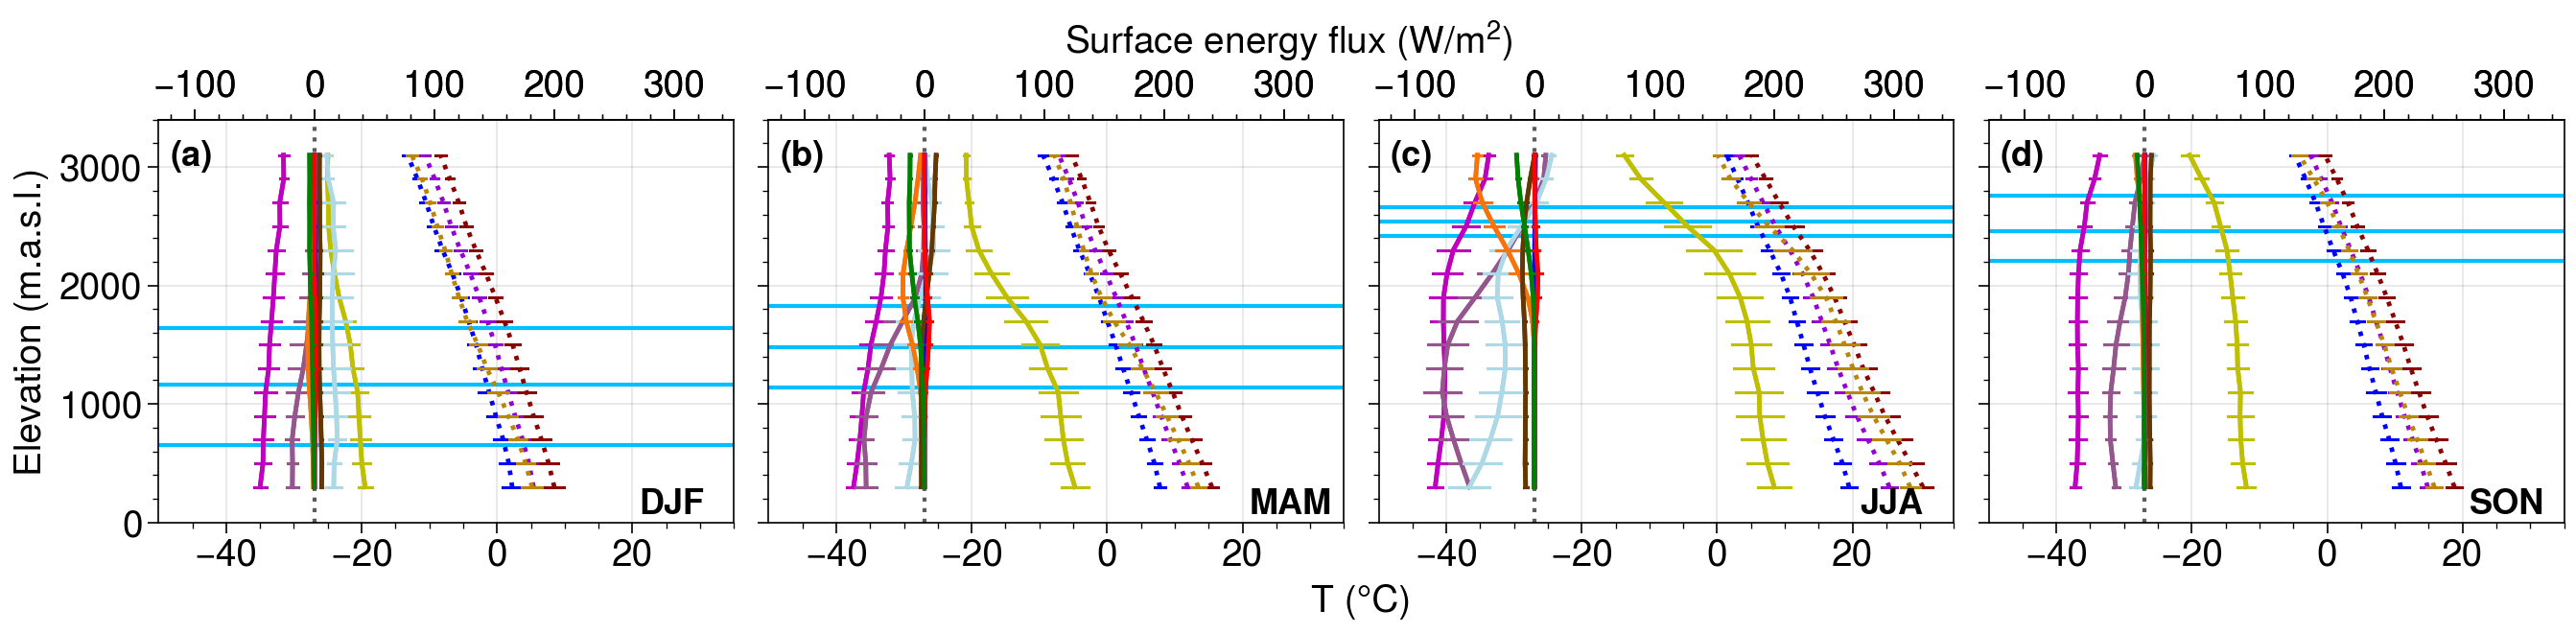

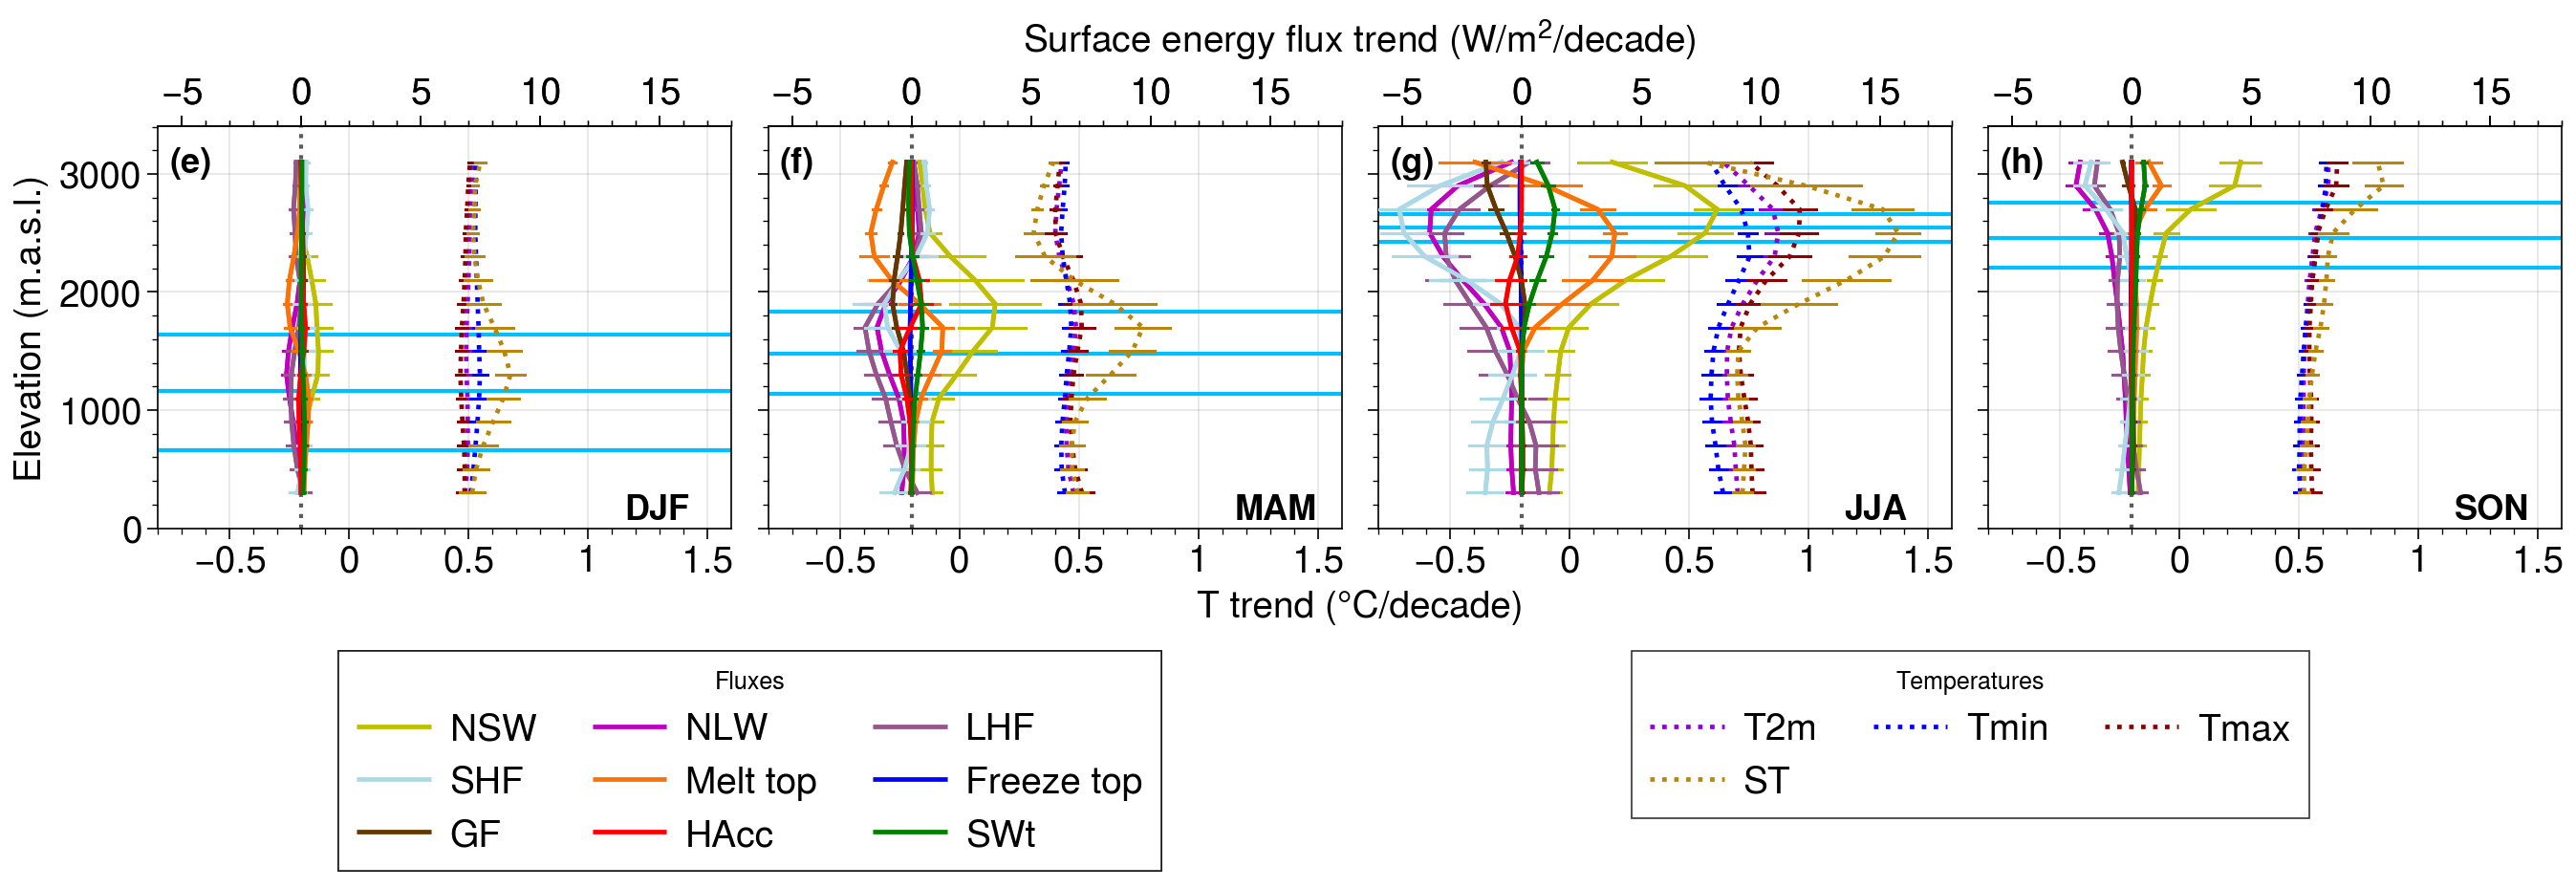

In [16]:
pplt.rc['figure.facecolor'] = 'white'
import string

seasons=['DJF','MAM','JJA','SON']
first_year = 55
last_year = None

# ------------------------ MARv3.14 7km simulation mean values ----------------------------

multiplier = 1 # =10 if trends per decade
snowlines = True

colors = ['darkviolet','b','darkred','darkgoldenrod','y','m','purple','lightblue','orange','blue','brown','r','green']#,'k']
leg_labels_null = ['','','','','','','','','','','','','','']
leg_labels_full = ['T2m','Tmin','Tmax','ST','NSW','NLW','LHF','SHF','Melt top','Freeze top','GF','HAcc','SWt']#,'Surfbal']
leg_labels = [leg_labels_full,leg_labels_null,leg_labels_null,leg_labels_null]

ds_slopes = ds314_MPI_SSP585.mean(dim='Year')
ds_slopes_Hlev, ds_slopes_Hlev_std = altitude_lev_slopes(ds_slopes,levels=levels)

pplt.rc.update(small=14, large=12)
with pplt.rc.context({'suptitle.weight': 'normal', 'suptitle.size': 14}):
    f, axs = pplt.subplots(ncols=4,axwidth=3.,axheight=2.1,top=5)

#f.format(top=5)
axs2 = axs.twiny()

for seas in range(4):
    ax = axs[seas]
    ax2 = axs2[seas]
    for i,var in enumerate(leg_labels_full):
        if var=='T2m' or var=='Tmax' or var=='Tmin' or var=='ST':
            ax.plot(multiplier*ds_slopes_Hlev[var].isel(season=seas),H_levels,c=colors[i],linestyle=':',
                    label=leg_labels[seas][i],linewidth=1.7)
        else:
            ax2.plot(multiplier*ds_slopes_Hlev[var].isel(season=seas),H_levels,c=colors[i],label=leg_labels[seas][i],linewidth=1.7)
        for lev in range(len(levels)): # spatial standard deviation
            if var=='T2m' or var=='Tmax' or var=='Tmin' or var=='ST':
                slope_var = ds_slopes_Hlev[var].isel(season=seas)[lev]
                std_var = ds_slopes_Hlev_std[var].isel(season=seas)[lev]
                ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c=colors[i],linewidth=1.1)
            else:
                slope_var = ds_slopes_Hlev[var].isel(season=seas)[lev]
                std_var = ds_slopes_Hlev_std[var].isel(season=seas)[lev]
                ax2.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c=colors[i],linewidth=1.1)
    
    if snowlines:
        ax.hlines(mean10_snowline_seas[0][first_year:last_year,seas].mean(),-55,35,c='deepskyblue')
        ax.hlines(mean10_snowline_seas[1][first_year:last_year,seas].mean(),-55,35,c='deepskyblue')
        ax.hlines(mean10_snowline_seas[2][first_year:last_year,seas].mean(),-55,35,c='deepskyblue')
    
    ax.set_xlim(-50,35)
    ax.text(21., 75, seasons[seas], fontsize=13,fontweight='semibold')
    ax.set_ylim(0,3400)
    ax2.vlines(0,0,3500,c='k',linestyle=':',alpha=0.4)
    ax2.set_xlim(-130,350)
    ax2.format(xlabel='')

f.text(0.5, 0.9, "Surface energy flux (W/$m^2$)",
         ha="center", va="bottom",size=14)
#f.legend(loc='b',prop = { "size": 14 },ncols=4)
xLabel = 'T (°C)'
Suptitle='Surface energy flux (W/$m^2$)'
#axs.format(abc='a)', abcloc='ul', abcweight='bold', abcsize=12)
# Add manual subplot labels (a–h, for example)
letters = list(string.ascii_lowercase)  # ['a','b','c',...]
labels = letters[:len(axs)]  # e.g. ['a','b','c','d'] or ['e','f','g','h']

# You can offset starting letter manually (e.g. start at 'e')
start_index = 0  # 0-based, so 4 = 'e'
labels = letters[start_index:start_index+len(axs)]

for i, ax in enumerate(axs):
    ax.text(
        0.02, 0.95, f"({labels[i]})",
        transform=ax.transAxes,
        fontsize=13,
        fontweight='bold',
        va='top', ha='left'
    )

f.format(xlabel=xLabel,ylabel='Elevation (m.a.s.l.)')


# ------------------------ MARv3.14 7km simulation trends ----------------------------

multiplier = 10 # =10 if trends per decade
snowlines = True

colors = ['darkviolet','b','darkred','darkgoldenrod','y','m','purple','lightblue','orange','blue','brown','r','green']#,'k']
leg_labels_null = ['','','','','','','','','','','','','','']
leg_labels_full = ['T2m','Tmin','Tmax','ST','NSW','NLW','LHF','SHF','Melt top','Freeze top','GF','HAcc','SWt']#,'Surfbal']
leg_labels = [leg_labels_full,leg_labels_null,leg_labels_null,leg_labels_null]

ds_slopes = ds314_MPI_SSP585.polyfit('Year', deg=1)
ds_slopes_Hlev, ds_slopes_Hlev_std = altitude_lev_slopes(ds_slopes,levels=levels)

pplt.rc.update(small=14, large=12)
with pplt.rc.context({'suptitle.weight': 'normal', 'suptitle.size': 14}):
    #f, axs = pplt.subplots(ncols=4,axwidth=3.,axheight=3.)
    f, axs = pplt.subplots(ncols=4,axwidth=3.,axheight=2.1,sharey=True,tight=True)
axs2 = axs.twiny()

lines_dashed = []
lines_solid = []

for seas in range(4):
    ax = axs[seas]
    ax2 = axs2[seas]
    for i,var in enumerate(leg_labels_full):
        if var=='T2m' or var=='Tmax' or var=='Tmin' or var=='ST':
            line_dashed, = ax.plot(multiplier*ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(season=seas,degree=0),H_levels,c=colors[i],linestyle=':',
                    label=leg_labels[seas][i],linewidth=1.7) # Writing line, = ... unpacks the first element of the list into the variable line.
            lines_dashed.append(line_dashed)
        else:
            line_solid, = ax2.plot(multiplier*ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(season=seas,degree=0),H_levels,c=colors[i],label=leg_labels[seas][i],
                                  linewidth=1.7)
            lines_solid.append(line_solid)
        for lev in range(len(levels)): # spatial standard deviation
            if var=='T2m' or var=='Tmax' or var=='Tmin' or var=='ST':
                slope_var = ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(season=seas,degree=0)[lev]
                std_var = ds_slopes_Hlev_std[var+'_polyfit_coefficients'].isel(season=seas,degree=0)[lev]
                ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c=colors[i],linewidth=1.1)
            else:
                slope_var = ds_slopes_Hlev[var+'_polyfit_coefficients'].isel(season=seas,degree=0)[lev]
                std_var = ds_slopes_Hlev_std[var+'_polyfit_coefficients'].isel(season=seas,degree=0)[lev]
                ax2.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c=colors[i],linewidth=1.1)
    
    if snowlines:
        ax.hlines(mean10_snowline_seas[0][first_year:last_year,seas].mean(),-55,35,c='deepskyblue')
        ax.hlines(mean10_snowline_seas[1][first_year:last_year,seas].mean(),-55,35,c='deepskyblue')
        ax.hlines(mean10_snowline_seas[2][first_year:last_year,seas].mean(),-55,35,c='deepskyblue')
    
    ax.set_xlim(-0.8,1.6)
    ax.text(1.15, 75, seasons[seas], fontsize=13,fontweight='semibold')
    ax.set_ylim(0,3400)
    ax2.vlines(0,0,3500,c='k',linestyle=':',alpha=0.4)
    ax2.set_xlim(-6,18)
    ax2.format(xlabel='')

# Add manual subplot labels (a–h, for example)
letters = list(string.ascii_lowercase)  # ['a','b','c',...]
labels = letters[:len(axs)]  # e.g. ['a','b','c','d'] or ['e','f','g','h']

# You can offset starting letter manually (e.g. start at 'e')
start_index = 4  # 0-based, so 4 = 'e'
labels = letters[start_index:start_index+len(axs)]

for i, ax in enumerate(axs):
    ax.text(
        0.02, 0.95, f"({labels[i]})",
        transform=ax.transAxes,
        fontsize=13,
        fontweight='bold',
        va='top', ha='left'
    )

# Create two separate legend boxes
leg1 = f.legend(handles=lines_solid, title="Fluxes", loc="b",prop = { "size": 14 },cols=(1,2))
leg2 = f.legend(handles=lines_dashed, title="Temperatures", loc="b",prop = { "size": 14 },cols=(3,4))

# Ensure both are displayed
f.add_artist(leg1)

#f.legend(loc='b',prop = { "size": 14 },ncols=4)
xLabel = 'T trend (°C/decade)'
Suptitle='Surface energy flux trend (W/$m^2$/decade)'

axs.format(xlabel=xLabel,ylabel='Elevation (m.a.s.l.)',suptitle=Suptitle)#,rowlabels=['MARv3.14 7km no lim'])


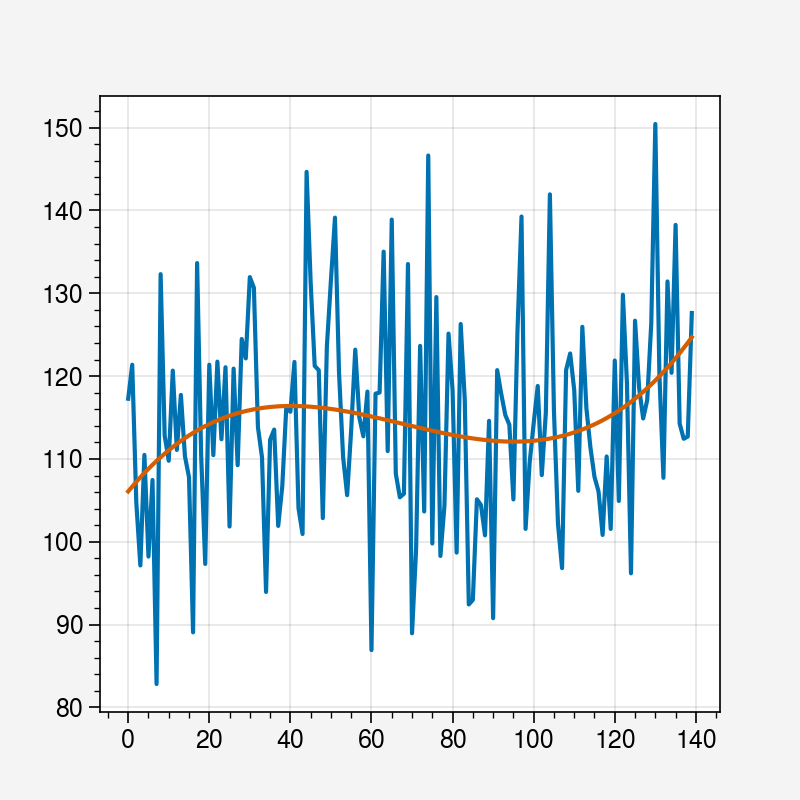

In [32]:
plt.plot(ds314_MPI.NSW[:,1,70,30])
plt.plot(da_smooth.NSW[1,70,30,:])

In [48]:
da_smooth.isel(Year=slice(89,89+50))

<xarray.Dataset>
Dimensions:   (season: 4, y: 91, x: 139, Year: 50)
Coordinates:
  * x         (x) float32 -259.0 -252.0 -245.0 -238.0 ... 693.0 700.0 707.0
  * y         (y) float32 -168.0 -161.0 -154.0 -147.0 ... 448.0 455.0 462.0
    ztqlev    float32 2.0
    atmlay    float32 0.9997
  * season    (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * Year      (Year) int64 2050 2051 2052 2053 2054 ... 2095 2096 2097 2098 2099
Data variables:
    TTz       (season, y, x, Year) float64 11.85 11.88 11.92 ... 15.57 15.65
    ST        (season, y, x, Year) float64 13.47 13.5 13.53 ... 16.27 16.36
    TTmax     (season, y, x, Year) float64 13.0 13.04 13.07 ... 19.6 19.7 19.81
    NSW       (season, y, x, Year) float64 75.84 75.84 75.83 ... 78.07 78.29
    melt_top  (season, y, x, Year) float64 0.0 0.0 0.0 ... -0.01386 -0.01008

In [28]:
l = 50 # length of periods

n = 140-l # number of periods

slopes_periods = da_smooth.isel(Year=slice(0,50)).polyfit('Year', deg=1)

for year in np.arange(1,n):
    print(year,end=' ')
    endyear = year+l
    period_slope = da_smooth.isel(Year=slice(year,endyear)).polyfit('Year', deg=1)
    slopes_periods = xr.concat([slopes_periods,period_slope], dim='period')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 

In [29]:
periods = np.arange(0,90)

slopes_periods = slopes_periods.assign_coords(period=("period", periods))

slopes_periods

<xarray.Dataset>
Dimensions:                        (season: 4, y: 91, x: 139, degree: 2,
                                    period: 90)
Coordinates:
  * season                         (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * y                              (y) float32 -168.0 -161.0 ... 455.0 462.0
  * x                              (x) float32 -259.0 -252.0 ... 700.0 707.0
  * degree                         (degree) int64 1 0
  * period                         (period) int64 0 1 2 3 4 5 ... 85 86 87 88 89
Data variables:
    TTz_polyfit_coefficients       (period, degree, season, y, x) float64 0.0...
    ST_polyfit_coefficients        (period, degree, season, y, x) float64 0.0...
    TTmax_polyfit_coefficients     (period, degree, season, y, x) float64 0.0...
    NSW_polyfit_coefficients       (period, degree, season, y, x) float64 -0....
    melt_top_polyfit_coefficients  (period, degree, season, y, x) float64 0.0...

In [38]:
height_max_T_k5_MAM, value_max_T_k5_MAM = spline_fit_4reg(slopes_periods['TTz_polyfit_coefficients'].sel(degree=1,season='MAM'),
                                                          knot_numbers=5,yfitminpercent=0.10,yfitmaxpercent=0.1)


k =  3
3   3 (3551,)


In [37]:
height_max_Tmax_k5_MAM, value_max_Tmax_k5_MAM = spline_fit_4reg(slopes_periods['TTmax_polyfit_coefficients'].sel(degree=1,season='MAM'),
                                                          knot_numbers=5,yfitminpercent=0.10,yfitmaxpercent=0.1)

height_max_ST_k5_MAM, value_max_ST_k5_MAM = spline_fit_4reg(slopes_periods['ST_polyfit_coefficients'].sel(degree=1,season='MAM'),
                                                          knot_numbers=5,yfitminpercent=0.10,yfitmaxpercent=0.1)

height_max_NSW_k5_MAM, value_max_NSW_k5_MAM = spline_fit_4reg(slopes_periods['NSW_polyfit_coefficients'].sel(degree=1,season='MAM'),
                                                          knot_numbers=5,yfitminpercent=0.10,yfitmaxpercent=0.1)

height_max_melt_top_k5_MAM, value_max_melt_top_k5_MAM = spline_fit_4reg(slopes_periods['melt_top_polyfit_coefficients'].sel(degree=1,season='MAM'),
                                                          knot_numbers=5,yfitminpercent=0.10,yfitmaxpercent=0.1)

k =  3
3   3 (3551,)
k =  3
3   3 (3551,)
k =  3
3   3 (3551,)
k =  3
3   3 (3551,)


In [36]:
height_max_T_k5_JJA, value_max_T_k5_JJA = spline_fit_4reg(slopes_periods['TTz_polyfit_coefficients'].sel(degree=1,season='JJA'),
                                                          knot_numbers=5,yfitminpercent=10,yfitmaxpercent=1)

height_max_Tmax_k5_JJA, value_max_Tmax_k5_JJA = spline_fit_4reg(slopes_periods['TTmax_polyfit_coefficients'].sel(degree=1,season='JJA'),
                                                          knot_numbers=5,yfitminpercent=10,yfitmaxpercent=1)

height_max_ST_k5_JJA, value_max_ST_k5_JJA = spline_fit_4reg(slopes_periods['ST_polyfit_coefficients'].sel(degree=1,season='JJA'),
                                                          knot_numbers=5,yfitminpercent=10,yfitmaxpercent=1)

height_max_NSW_k5_JJA, value_max_NSW_k5_JJA = spline_fit_4reg(slopes_periods['NSW_polyfit_coefficients'].sel(degree=1,season='JJA'),
                                                          knot_numbers=5,yfitminpercent=10,yfitmaxpercent=1)

height_max_melt_top_k5_JJA, value_max_melt_top_k5_JJA = spline_fit_4reg(slopes_periods['melt_top_polyfit_coefficients'].sel(degree=1,season='JJA'),
                                                          knot_numbers=5,yfitminpercent=10,yfitmaxpercent=1)

355   35 (3551,)
355   35 (3551,)
355   35 (3551,)
355   35 (3551,)
355   35 (3551,)


In [37]:
height_max_T_k5_SON, value_max_T_k5_SON = spline_fit_4reg(slopes_periods['TTz_polyfit_coefficients'].sel(degree=1,season='SON'),
                                                          knot_numbers=5,yfitminpercent=10,yfitmaxpercent=1)

height_max_Tmax_k5_SON, value_max_Tmax_k5_SON = spline_fit_4reg(slopes_periods['TTmax_polyfit_coefficients'].sel(degree=1,season='SON'),
                                                          knot_numbers=5,yfitminpercent=10,yfitmaxpercent=1)

height_max_ST_k5_SON, value_max_ST_k5_SON = spline_fit_4reg(slopes_periods['ST_polyfit_coefficients'].sel(degree=1,season='SON'),
                                                          knot_numbers=5,yfitminpercent=10,yfitmaxpercent=1)

height_max_NSW_k5_SON, value_max_NSW_k5_SON = spline_fit_4reg(slopes_periods['NSW_polyfit_coefficients'].sel(degree=1,season='SON'),
                                                          knot_numbers=5,yfitminpercent=10,yfitmaxpercent=1)

height_max_melt_top_k5_SON, value_max_melt_top_k5_SON = spline_fit_4reg(slopes_periods['melt_top_polyfit_coefficients'].sel(degree=1,season='SON'),
                                                          knot_numbers=5,yfitminpercent=10,yfitmaxpercent=1)

355   35 (3551,)
355   35 (3551,)
355   35 (3551,)
355   35 (3551,)
355   35 (3551,)


In [38]:
height_max_T_k5_DJF, value_max_T_k5_DJF = spline_fit_4reg(slopes_periods['TTz_polyfit_coefficients'].sel(degree=1,season='DJF'),
                                                          knot_numbers=5,yfitminpercent=10,yfitmaxpercent=1)

height_max_Tmax_k5_DJF, value_max_Tmax_k5_DJF = spline_fit_4reg(slopes_periods['TTmax_polyfit_coefficients'].sel(degree=1,season='DJF'),
                                                          knot_numbers=5,yfitminpercent=10,yfitmaxpercent=1)

height_max_ST_k5_DJF, value_max_ST_k5_DJF = spline_fit_4reg(slopes_periods['ST_polyfit_coefficients'].sel(degree=1,season='DJF'),
                                                          knot_numbers=5,yfitminpercent=10,yfitmaxpercent=1)

height_max_NSW_k5_DJF, value_max_NSW_k5_DJF = spline_fit_4reg(slopes_periods['NSW_polyfit_coefficients'].sel(degree=1,season='DJF'),
                                                          knot_numbers=5,yfitminpercent=10,yfitmaxpercent=1)

height_max_melt_top_k5_DJF, value_max_melt_top_k5_DJF = spline_fit_4reg(slopes_periods['melt_top_polyfit_coefficients'].sel(degree=1,season='DJF'),
                                                          knot_numbers=5,yfitminpercent=10,yfitmaxpercent=1)

355   35 (3551,)
355   35 (3551,)
355   35 (3551,)
355   35 (3551,)
355   35 (3551,)


3 3
3 3
3 3
3 3


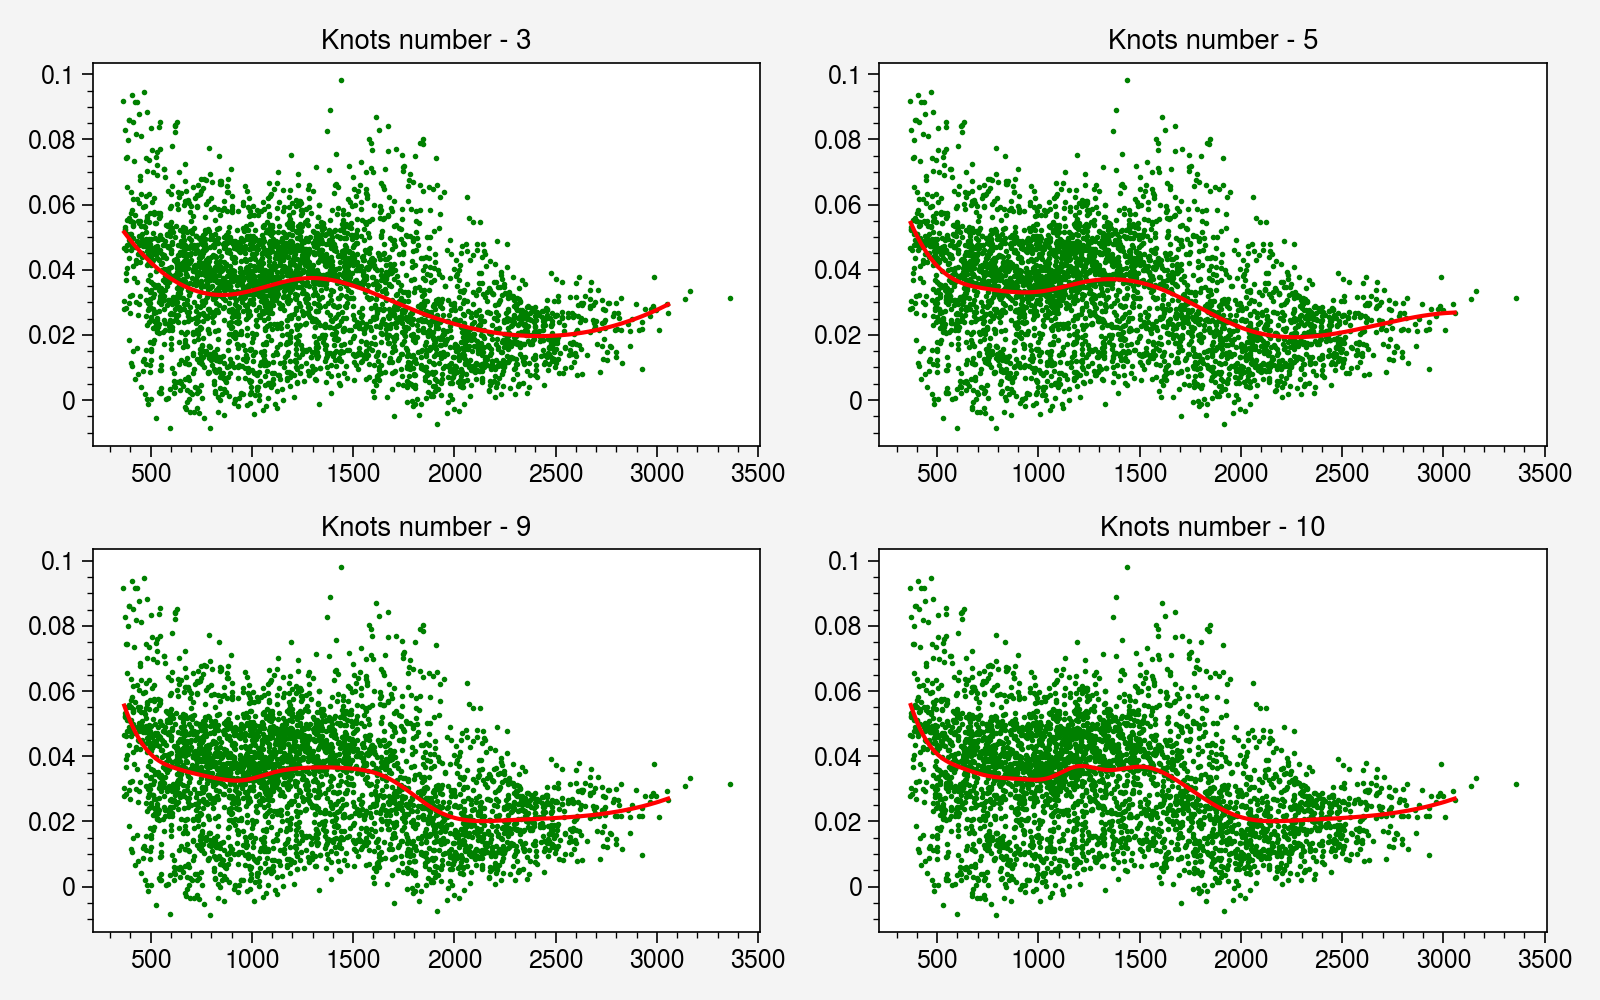

In [36]:
period=10

height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(alps))
vec_height = height[height.mask == False]

slope_NSW_MAM = 10*np.ma.masked_array(slopes_periods['TTz_polyfit_coefficients'].sel(degree=1,season='MAM')[period], mask=np.invert(alps))
vec_slope_NSW_MAM = slope_NSW_MAM[slope_NSW_MAM.mask == False]
        
vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_NSW_MAM), key=lambda pair: pair[0])]
vec_slope_NSW_MAM_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_NSW_MAM), key=lambda pair: pair[0])]


knots = [3, 5, 9, 10]
j=0

ig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

vec_slope_seas_srt = vec_slope_NSW_MAM_srt
# yfitminpercent=15
# yfitmaxpercent=10
yfitminpercent=0.1
yfitmaxpercent=0.1

for row in range(2):
    for col in range(2):
        ax[row][col].plot(vec_height_srt, vec_slope_NSW_MAM_srt, '.',c="g", markersize=2)

        height_new = np.linspace(0, 1, knots[j]+2)[1:-1]
        q_knots = np.quantile(vec_height_srt, height_new)
            
        t,c,k = interpolate.splrep(vec_height_srt, vec_slope_seas_srt, t=q_knots, s=1)
        yfit = interpolate.BSpline(t,c,k)(vec_height_srt)
            
        yfitmin = int(yfitminpercent/100*len(yfit))
        yfitmax = int(yfitmaxpercent/100*len(yfit))
        vec_height_srt_redux = vec_height_srt[yfitmin:-yfitmax]
        print(yfitmin,yfitmax)
        ax[row][col].plot(vec_height_srt[yfitmin:-yfitmax], yfit[yfitmin:-yfitmax], 'r')
        ax[row][col].set_title("Knots number - "+str(knots[j]))
        ax[row][col].grid()
        j=j+1
        
plt.tight_layout()        
plt.show()

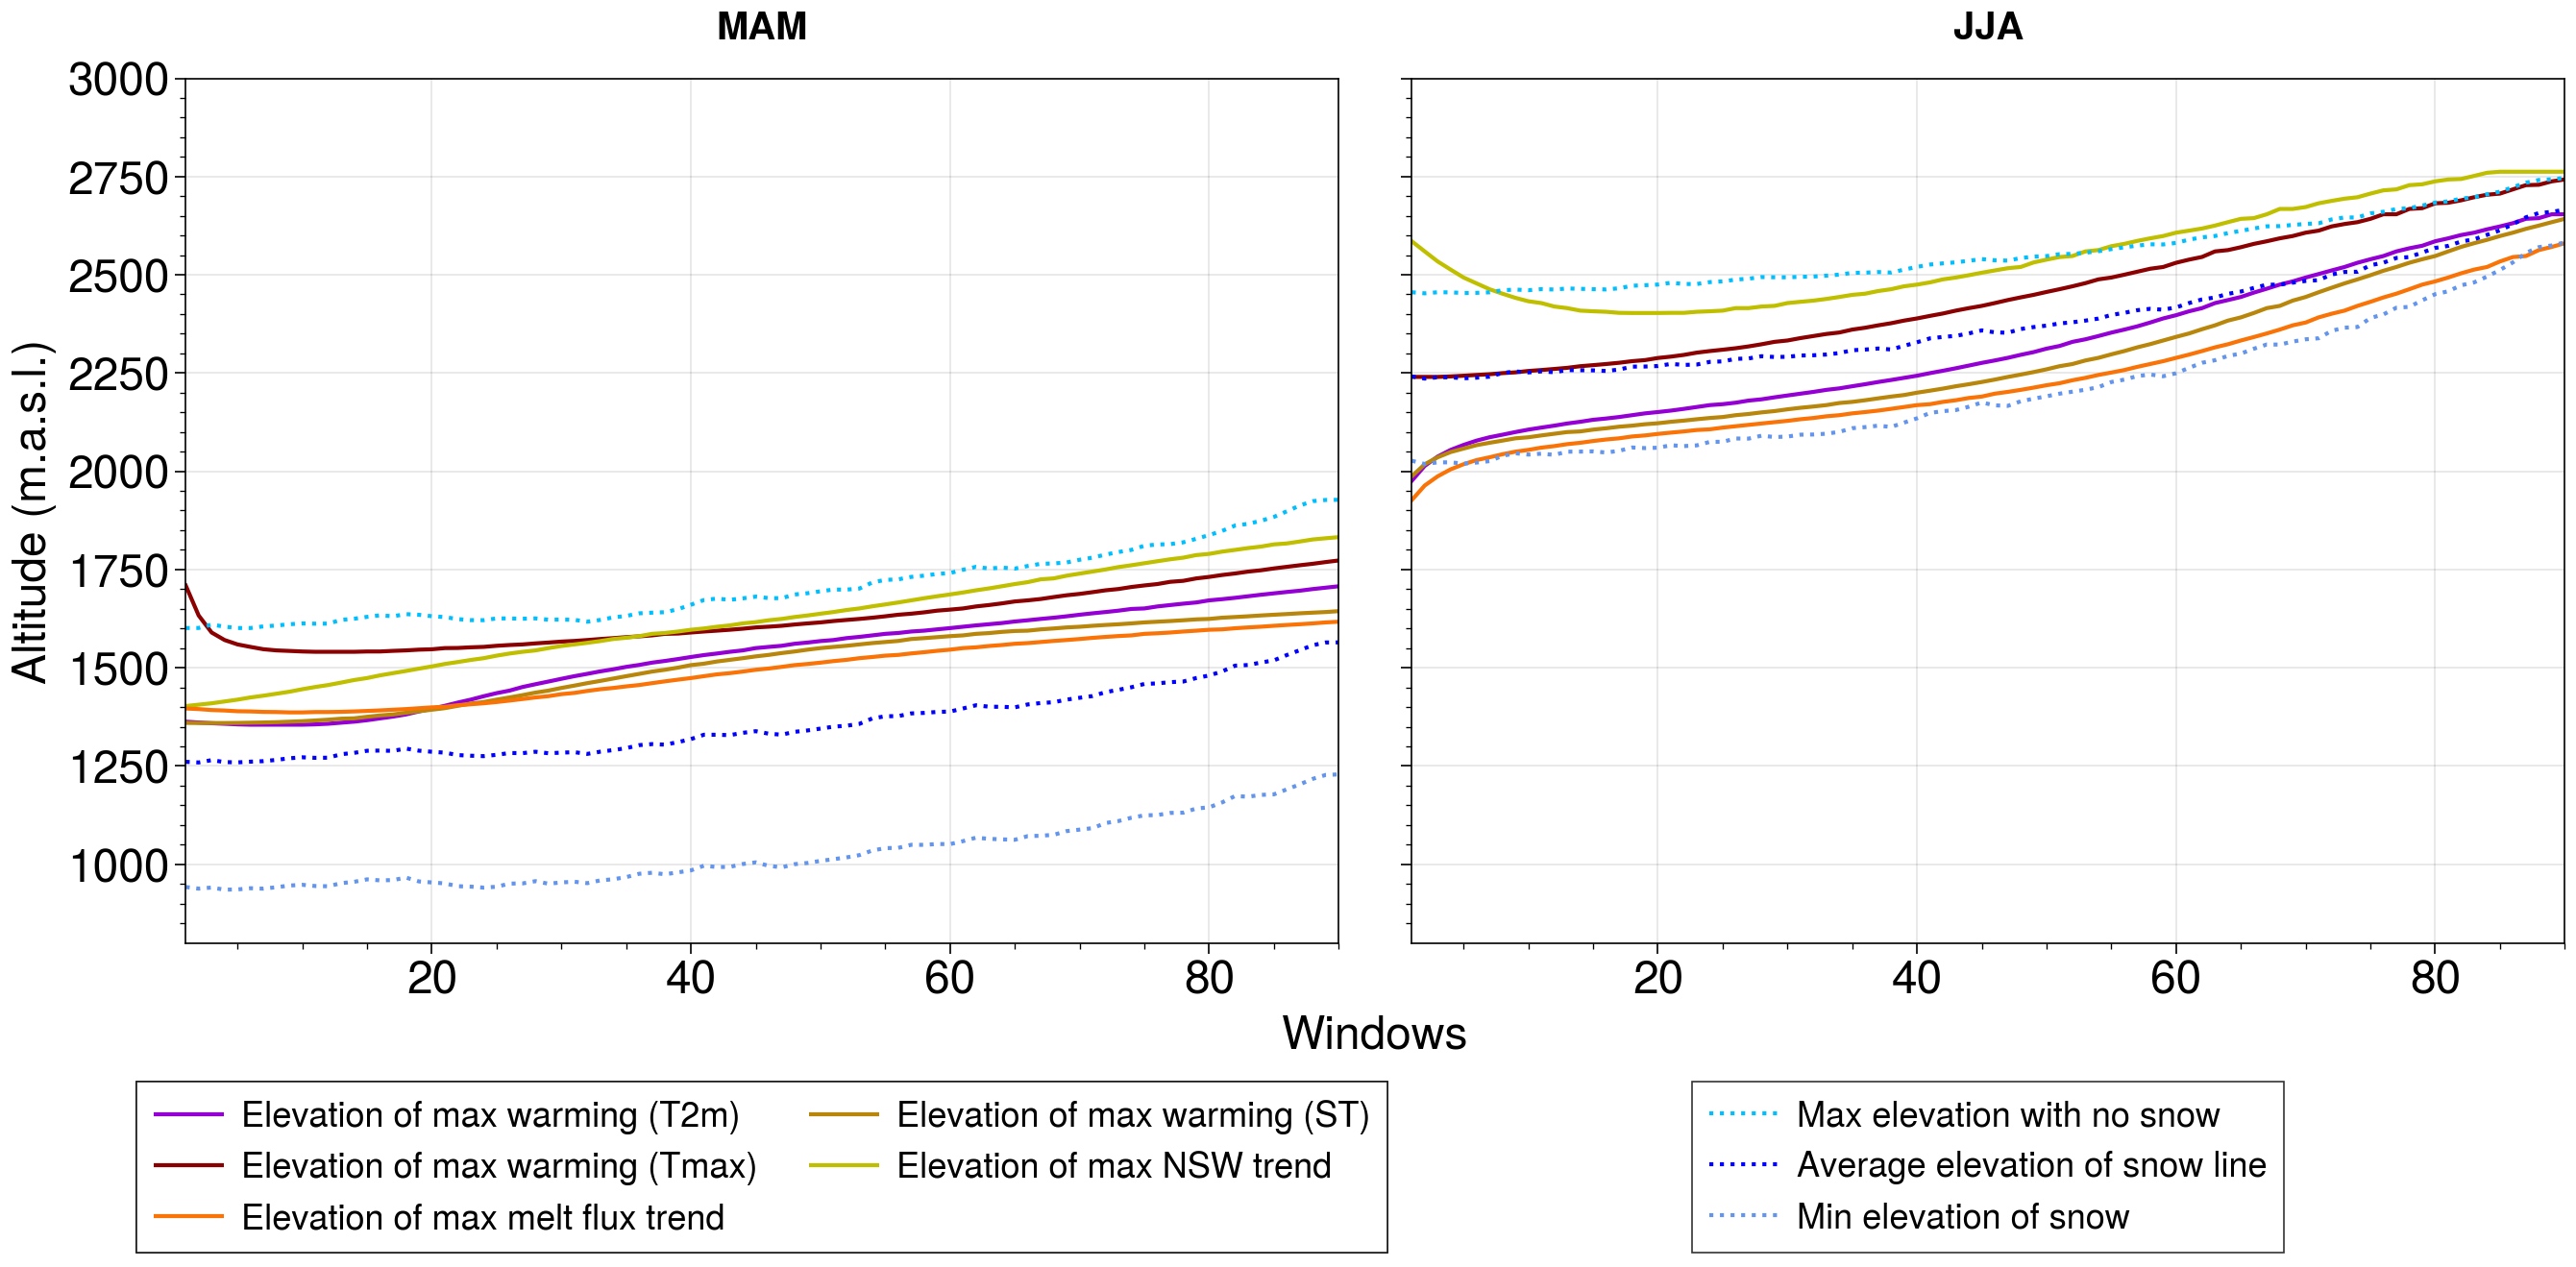

In [43]:
pplt.rc['figure.facecolor'] = 'white'


f,axs = pplt.subplots(axwidth=6,axheight=4.5,ncols=2)

periods = range(1,91)

# Spring - MAM
line1, = axs[0].plot(periods,height_max_T_k5_MAM,label='Elevation of max warming (T2m)',c='darkviolet')#,legend_kw={'fontsize':'30px'})
line2, = axs[0].plot(periods,height_max_ST_k5_MAM,label='Elevation of max warming (ST)',c='darkgoldenrod')

line3, = axs[0].plot(periods,height_max_Tmax_k5_MAM,c='darkred',label='Elevation of max warming (Tmax)')
line4, = axs[0].plot(periods,height_max_NSW_k5_MAM,c='y',label='Elevation of max NSW trend')
line5, = axs[0].plot(periods,height_max_melt_top_k5_MAM,c='orange',label='Elevation of max melt flux trend')
lines_solid = [line1, line2, line3, line4, line5]

line6, = axs[0].plot(periods,rollmean_50yrs_mean10_minH_snow_MAM,c='cornflowerblue',linestyle=':',label='Min elevation of snow')
line7, = axs[0].plot(periods,rollmean_50yrs_mean10_maxH_nosnow_MAM,c='deepskyblue',linestyle=':',label='Max elevation with no snow')
line8, = axs[0].plot(periods,rollmean_50yrs_mean10_average_minmax_snow_MAM,c='b',linestyle=':',label='Average elevation of snow line')
#axs[0].plot(rollmean_50yrs_mean1_minH_snow_MAM[0],c='lightskyblue',linestyle='--')
#axs[0].plot(rollmean_50yrs_mean1_maxH_nosnow_MAM[0],c='deepskyblue',linestyle='--')
#axs[0].plot(rollmean_50yrs_mean1_average_minmax_snow_MAM[0],c='skyblue',linestyle='--')
lines_dashed = [line7, line8, line6]

# Summer - JJA
axs[1].plot(periods,height_max_T_k5_JJA,c='darkviolet')#,legend_kw={'fontsize':'30px'})
axs[1].plot(periods,height_max_ST_k5_JJA,c='darkgoldenrod')

axs[1].plot(periods,height_max_Tmax_k5_JJA,c='darkred')
axs[1].plot(periods,height_max_NSW_k5_JJA,c='y')
axs[1].plot(periods,height_max_melt_top_k5_JJA,c='orange')


axs[1].plot(periods,rollmean_50yrs_mean10_minH_snow_JJA,c='cornflowerblue',linestyle=':')
axs[1].plot(periods,rollmean_50yrs_mean10_maxH_nosnow_JJA,c='deepskyblue',linestyle=':')
axs[1].plot(periods,rollmean_50yrs_mean10_average_minmax_snow_JJA,c='b',linestyle=':')

#f.legend(loc='b',prop = { "size": 16 })
# Create two separate legend boxes
leg1 = f.legend(handles=lines_solid, loc="b",prop = { "size": 13 },col=1,ncols=2)#title="Fluxes",
leg2 = f.legend(handles=lines_dashed, loc="b",prop = { "size": 13 },col=2,ncols=1)#title="Temperatures",

# Ensure both are displayed
f.add_artist(leg1)

axs.format(ylim=[800,3000],ylabel='Altitude (m.a.s.l.)',xlabel='Windows',fontsmallsize='24px',collabels=['MAM','JJA'],fontlargesize='20px')

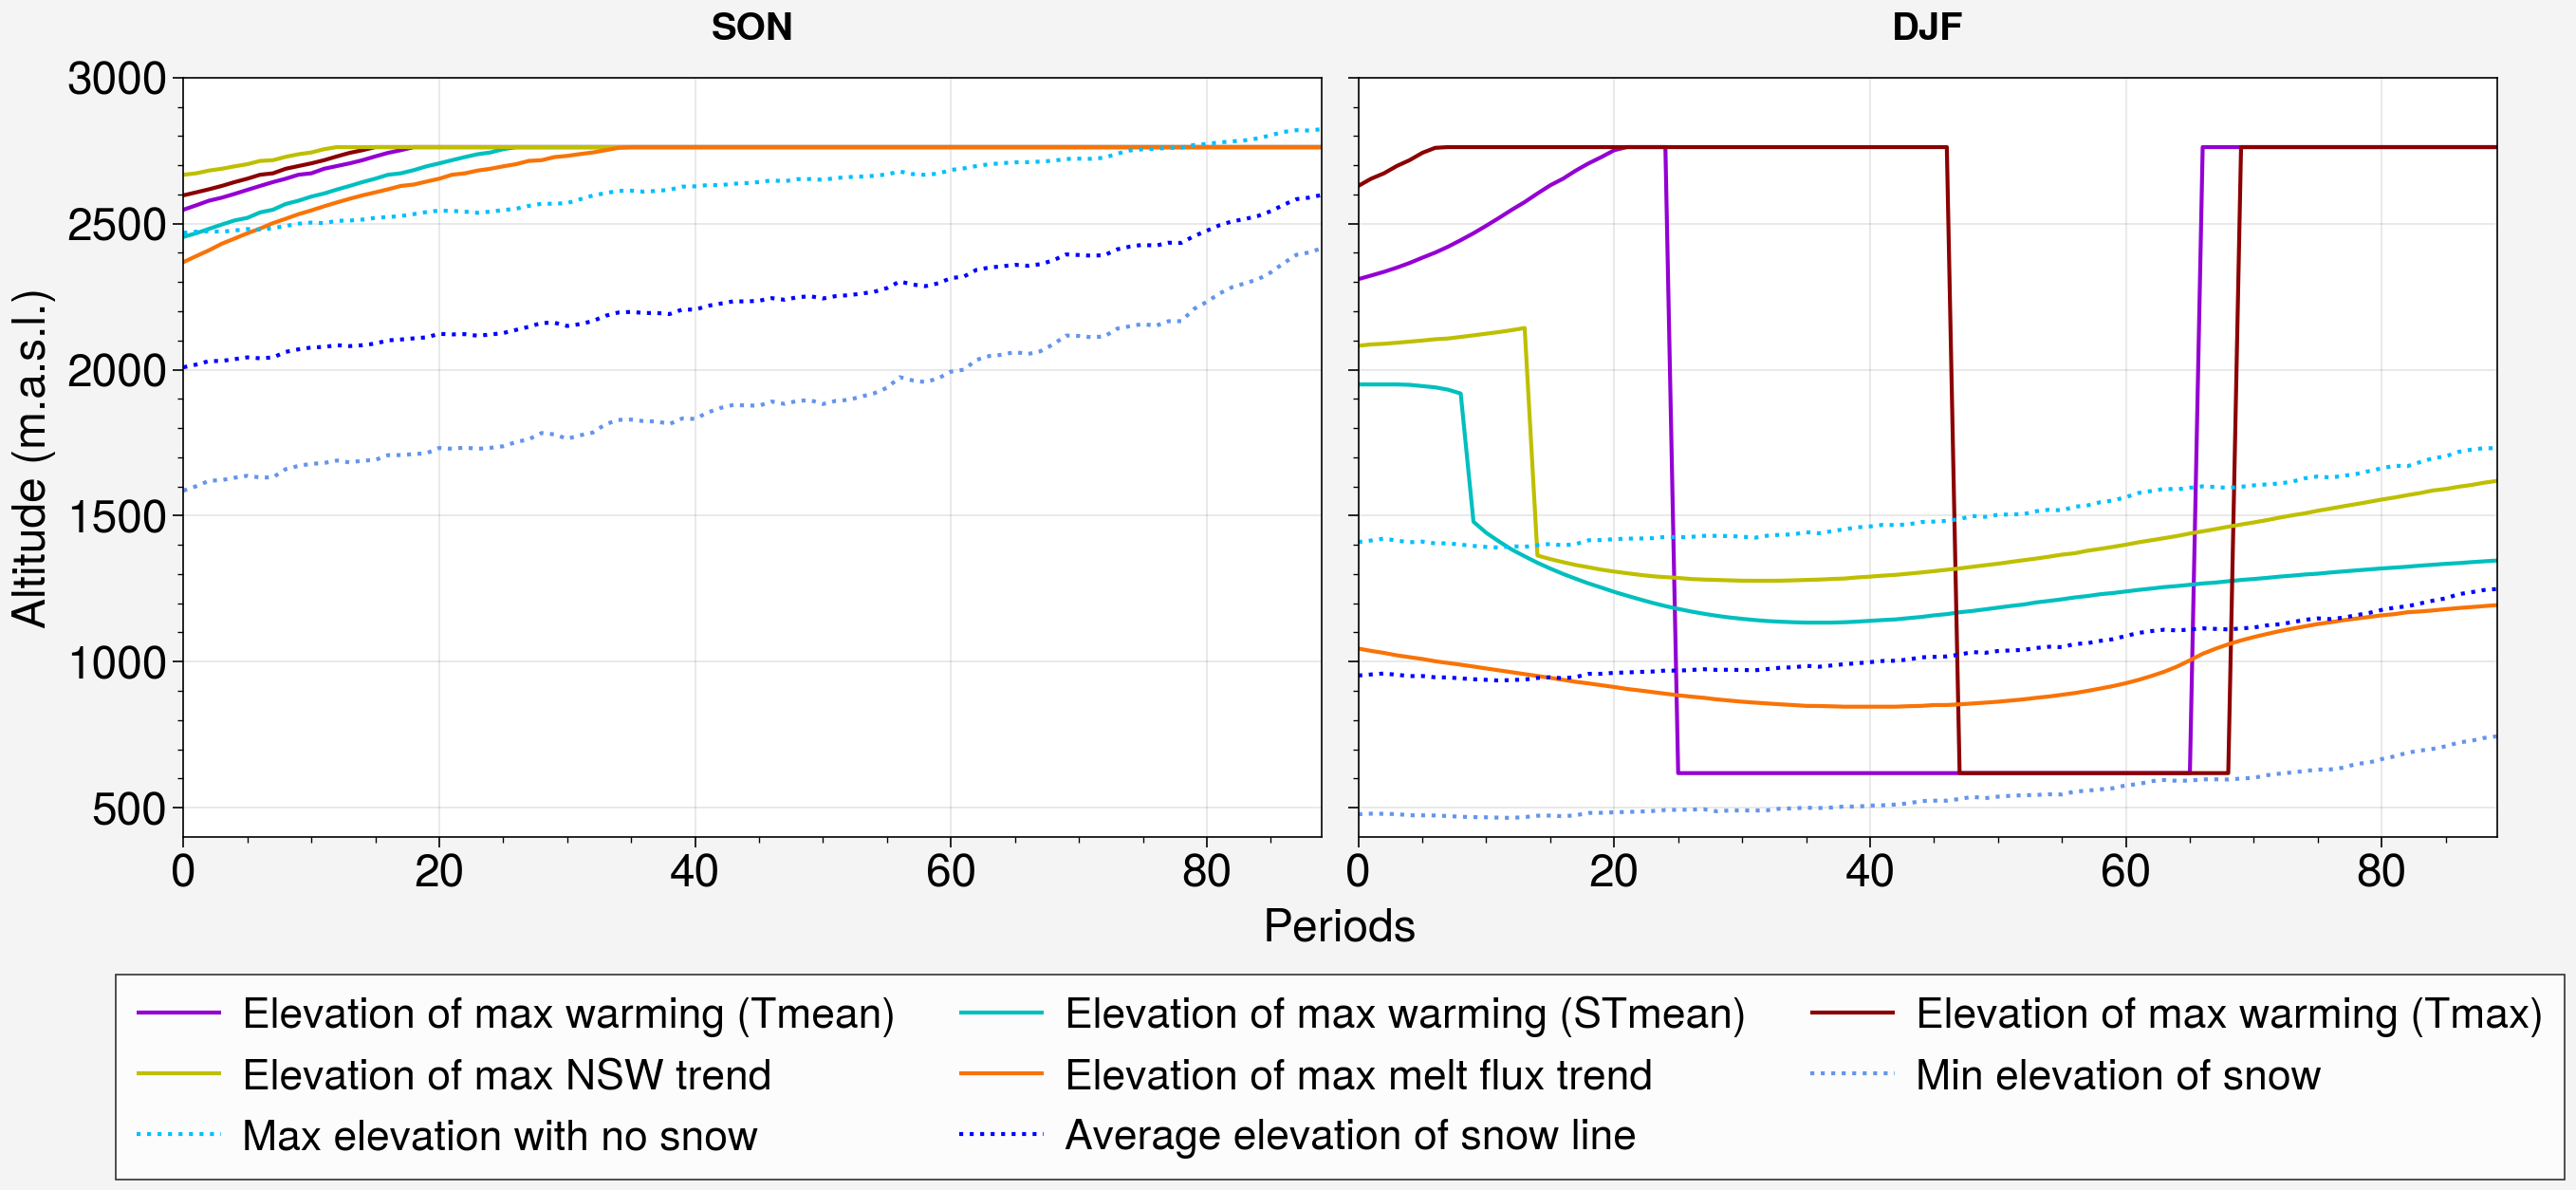

In [73]:
f,axs = pplt.subplots(axwidth=6,axheight=4,ncols=2)

# Autumn - SON
axs[0].plot(height_max_T_k5_SON,label='Elevation of max warming (Tmean)',c='darkviolet')#,legend_kw={'fontsize':'30px'})
axs[0].plot(height_max_ST_k5_SON,label='Elevation of max warming (STmean)',c='c')

axs[0].plot(height_max_Tmax_k5_SON,c='darkred',label='Elevation of max warming (Tmax)')
axs[0].plot(height_max_NSW_k5_SON,c='y',label='Elevation of max NSW trend')
axs[0].plot(height_max_melt_top_k5_SON,c='orange',label='Elevation of max melt flux trend')


axs[0].plot(rollmean_50yrs_mean10_minH_snow_SON,c='cornflowerblue',linestyle=':',label='Min elevation of snow')
axs[0].plot(rollmean_50yrs_mean10_maxH_nosnow_SON,c='deepskyblue',linestyle=':',label='Max elevation with no snow')
axs[0].plot(rollmean_50yrs_mean10_average_minmax_snow_SON,c='b',linestyle=':',label='Average elevation of snow line')
#axs[0].plot(rollmean_50yrs_mean1_minH_snow_MAM[0],c='lightskyblue',linestyle='--')
#axs[0].plot(rollmean_50yrs_mean1_maxH_nosnow_MAM[0],c='deepskyblue',linestyle='--')
#axs[0].plot(rollmean_50yrs_mean1_average_minmax_snow_MAM[0],c='skyblue',linestyle='--')

# Winter - DJF
axs[1].plot(height_max_T_k5_DJF,c='darkviolet')#,legend_kw={'fontsize':'30px'})
axs[1].plot(height_max_ST_k5_DJF,c='c')

axs[1].plot(height_max_Tmax_k5_DJF,c='darkred')
axs[1].plot(height_max_NSW_k5_DJF,c='y')
axs[1].plot(height_max_melt_top_k5_DJF,c='orange')


axs[1].plot(rollmean_50yrs_mean10_minH_snow_DJF,c='cornflowerblue',linestyle=':')
axs[1].plot(rollmean_50yrs_mean10_maxH_nosnow_DJF,c='deepskyblue',linestyle=':')
axs[1].plot(rollmean_50yrs_mean10_average_minmax_snow_DJF,c='b',linestyle=':')

f.legend(loc='b',prop = { "size": 16 })
axs.format(ylim=[400,3000],ylabel='Altitude (m.a.s.l.)',xlabel='Periods',fontsmallsize='24px',collabels=['SON','DJF'],fontlargesize='20px')